# Predict results of NBA games

provide some description


## Dataset preparation

### Import dependencies

In [2]:
import pandas as pd
import numpy as np

### Import dataset
link to data: https://stats.nba.com/teams/boxscores/?sort=gdate&dir=1

In [3]:
data = pd.read_csv("nba_data_new", sep = ",")
data['GAME DATE'] =pd.to_datetime(data['GAME DATE'])
data = data.sort_values(['GAME DATE'], ascending=True)
data.head()

,TEAM,MATCH UP,GAME DATE,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
1021,TOR,TOR vs. NOP,2019-10-22,W,265,130,42,103,40.8,14,...,84.2,16,41,57,23,7,3,17,24,8
474,LAC,LAC vs. LAL,2019-10-22,W,240,112,42,81,51.9,11,...,70.8,11,34,45,24,8,5,14,25,10
510,LAL,LAL @ LAC,2019-10-22,L,240,102,37,85,43.5,13,...,71.4,9,32,41,20,4,7,15,24,-10
693,NOP,NOP @ TOR,2019-10-22,L,265,122,43,102,42.2,19,...,85.0,16,37,53,30,4,9,19,34,-8
1093,WAS,WAS @ DAL,2019-10-23,L,240,100,37,93,39.8,11,...,83.3,11,36,47,26,6,3,17,32,-8


### Data restructurization

In [4]:
home = data[data['MATCH UP'].str.contains("vs")]
away = data[data['MATCH UP'].str.contains("@")]

home['MATCH UP'] = home['MATCH UP'].str.slice(8,11)
home = home.rename(columns = { 'MATCH UP' : 'TEAM_B'})
home = home.rename(columns = { 'TEAM' : 'TEAM_A'})

away['MATCH UP'] = away['MATCH UP'].str.slice(6,9)
away = away.rename(columns = { 'MATCH UP' : 'TEAM_A'})
away = away.rename(columns = { 'TEAM' : 'TEAM_B'})
away = away.drop(['W/L', 'MIN'],1)

nba_data = pd.merge(home, away, on = ['TEAM_A', 'TEAM_B', 'GAME DATE'], suffixes = ['_H', '_A'])
nba_data = nba_data.rename(columns = { 'TEAM_A' : 'HOME'})
nba_data = nba_data.rename(columns = { 'TEAM_B' : 'AWAY'})
nba_data['W/L'] = nba_data['W/L'].replace('W', 'H')
nba_data['W/L'] = nba_data['W/L'].replace('L', 'A')
nba_data = nba_data.rename(columns = { 'W/L' : 'RESULT'})

nba_data.head()

/home/michal/PycharmProjects/ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/michal/PycharmProjects/ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,HOME,AWAY,GAME DATE,RESULT,MIN,PTS_H,FGM_H,FGA_H,FG%_H,3PM_H,...,FT%_A,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,+/-_A
0,TOR,NOP,2019-10-22,H,265,130,42,103,40.8,14,...,85.0,16,37,53,30,4,9,19,34,-8
1,LAC,LAL,2019-10-22,H,240,112,42,81,51.9,11,...,71.4,9,32,41,20,4,7,15,24,-10
2,BKN,MIN,2019-10-23,A,265,126,48,101,47.5,15,...,78.6,12,40,52,23,9,4,13,22,1
3,CHA,CHI,2019-10-23,H,240,126,45,88,51.1,23,...,81.8,20,29,49,25,11,4,12,20,-1
4,DAL,WAS,2019-10-23,H,240,108,35,76,46.1,11,...,83.3,11,36,47,26,6,3,17,32,-8


## Data Exploration


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = nba_data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = nba_data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = np.sum(nba_data['RESULT'] == 'H')

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print(f"Total number of matches: {n_matches}")
print(f"Number of features: {n_features}")
print(f"Number of matches won by home team: {n_homewins}")
print(f"Win rate of home team: {win_rate}%")

Total number of matches: 547
Number of features: 42
Number of matches won by home team: 312
Win rate of home team: 57.038391224862885%


### Create new variable - ELO ranking

ELO ranking is the way to estimate power of a player or a team in various sports. Especially it is very popular in chess.
We have to define probability of win based on ELO ranking of two teams. Of course team with higher ELO has better chance to win the game.

$$p_{win}(ELO_1, ELO_2) = \frac{1}{1+10^{-\frac{ELO - ELO_2}{400}}}$$


In [7]:
def p_win(elo_rank_1, elo_rank_2):
    return 1/(1 + 10**(-(elo_rank_1-elo_rank_2)/400)  )

We have to be able to calculate the gain in ELO ranking for the team, which actually win the game. The formula for gain:

* if first team wins then gain in ELO ranking ($\Delta$) is equal to:
    $$\Delta = 20\times(1-p_{win}(ELO_1, ELO_2)$$
* if second team wins then gain in ELO ranking ($\Delta$) is equal to:
    $$\Delta = 20\times(1-p_{win}(ELO_2, ELO_1)$$
    
I analyzed all games from the begginning of the season and obtained final ELO ranking for every team


In [8]:
teams = nba_data["HOME"].unique()
n_teams = np.shape(teams)[0]

elo_start = 1500
elo = dict(zip(teams, np.repeat(elo_start, n_teams)))

for index, row in nba_data.iterrows():
    home = row['HOME']
    away = row['AWAY']
    
    home_elo = elo[home]
    away_elo = elo[away]
    
    if row['RESULT'] == 'H':
        elo[home] += 20*(1-p_win(home_elo, away_elo))
    else:
        elo[away] += 20*(1-p_win(away_elo, home_elo))
 
{k: v for k, v in sorted(elo.items(), key=lambda item: item[1], reverse=True)}


{'MIL': 1764.4499619715216,
 'LAL': 1747.661457086966,
 'MIA': 1737.7429740483572,
 'LAC': 1732.7285813729004,
 'DEN': 1726.7102632003282,
 'BOS': 1723.853692645112,
 'HOU': 1723.3514842697793,
 'PHI': 1720.772714035593,
 'UTA': 1719.1160768117666,
 'TOR': 1717.5690219802163,
 'IND': 1715.646058224364,
 'DAL': 1713.8668085887036,
 'OKC': 1699.1676655609328,
 'ORL': 1670.4494844144494,
 'MEM': 1660.6929374816366,
 'SAS': 1656.732812416082,
 'BKN': 1655.4399133470129,
 'CHA': 1649.2236922326736,
 'POR': 1646.0147563886337,
 'SAC': 1645.5158261601257,
 'PHX': 1638.8341831868422,
 'MIN': 1637.6824278190675,
 'WAS': 1635.88548038789,
 'NOP': 1634.7703011520343,
 'CHI': 1630.9820946636564,
 'DET': 1630.677244845093,
 'NYK': 1608.464243371559,
 'CLE': 1603.9533402442962,
 'GSW': 1598.8747084247,
 'ATL': 1588.753969151456}

## Finding important predictors

First, I used my dataset to extract important features...


### Import dependencies

In [9]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.discrete.discrete_model as sm

### Train test split

In [10]:
nba_data.columns

Index(['HOME', 'AWAY', 'GAME DATE', 'RESULT', 'MIN', 'PTS_H', 'FGM_H', 'FGA_H',
       'FG%_H', '3PM_H', '3PA_H', '3P%_H', 'FTM_H', 'FTA_H', 'FT%_H', 'OREB_H',
       'DREB_H', 'REB_H', 'AST_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H', '+/-_H',
       'PTS_A', 'FGM_A', 'FGA_A', 'FG%_A', '3PM_A', '3PA_A', '3P%_A', 'FTM_A',
       'FTA_A', 'FT%_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A', 'STL_A',
       'BLK_A', 'TOV_A', 'PF_A', '+/-_A'],
      dtype='object')

In [11]:
#nba_data['ELO_H'] = nba_data['HOME'].map(elo)
#nba_data['ELO_A'] = nba_data['AWAY'].map(elo)
nba_data.head()


,HOME,AWAY,GAME DATE,RESULT,MIN,PTS_H,FGM_H,FGA_H,FG%_H,3PM_H,...,FT%_A,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,+/-_A
0,TOR,NOP,2019-10-22,H,265,130,42,103,40.8,14,...,85.0,16,37,53,30,4,9,19,34,-8
1,LAC,LAL,2019-10-22,H,240,112,42,81,51.9,11,...,71.4,9,32,41,20,4,7,15,24,-10
2,BKN,MIN,2019-10-23,A,265,126,48,101,47.5,15,...,78.6,12,40,52,23,9,4,13,22,1
3,CHA,CHI,2019-10-23,H,240,126,45,88,51.1,23,...,81.8,20,29,49,25,11,4,12,20,-1
4,DAL,WAS,2019-10-23,H,240,108,35,76,46.1,11,...,83.3,11,36,47,26,6,3,17,32,-8


### Basic feature selection

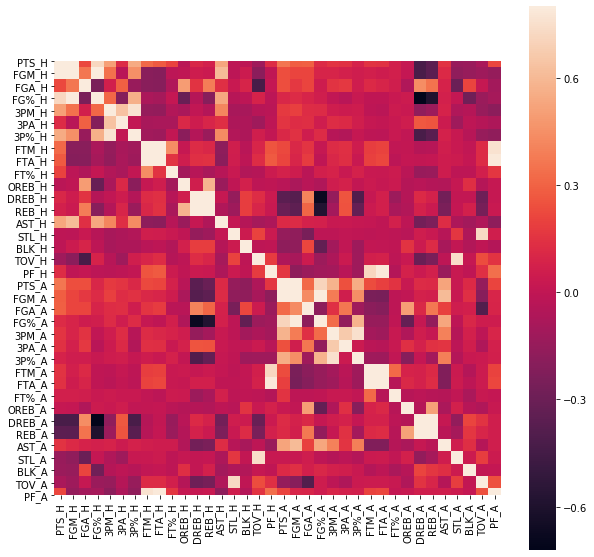

In [12]:
features = list(nba_data.drop(['HOME', 'AWAY', 'GAME DATE', 'RESULT'], axis=1).columns)

# doesn't make sens
features.remove('MIN')

features.remove('+/-_H')
features.remove('+/-_A')

corrmat = nba_data[features].corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, square=True)


columns = [ 'FGA_H', 'PTS_H', '3PA_H', 'FTA_H', 'REB_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H']

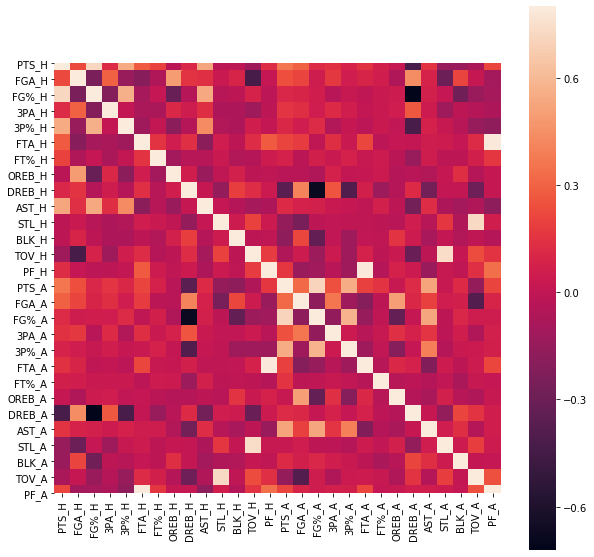

In [13]:
features = list(nba_data.drop(['HOME', 'AWAY', 'GAME DATE', 'RESULT'], axis=1).columns)

# doesn't make sens
features.remove('MIN')

features.remove('+/-_H')
features.remove('+/-_A')

features.remove('FGM_H')
features.remove('FGM_A')

features.remove('3PM_H')
features.remove('3PM_A')

features.remove('FTM_H')
features.remove('FTM_A')

features.remove('REB_H')
features.remove('REB_A')


corrmat = nba_data[features].corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, square=True)

In [14]:

X_train, X_test, y_train, y_test = train_test_split(nba_data[features].values , nba_data['RESULT'].values, test_size = 0.3,random_state=42)
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)

clf_RF.score(X_test, y_test)


0.8424242424242424

In [15]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = np.round(p_values,6)
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [16]:
clf_LR = LogisticReg(max_iter=1000)
clf_LR.fit(X_train, y_train)
print(clf_LR.p_values)

[0.058471 0.796561 0.845895 0.871126 0.85677  0.993967 0.846419 0.881307
 0.820754 0.665322 0.962737 0.816827 0.936109 0.968881 0.102607 0.901935
 0.784286 0.503088 0.731297 0.764482 0.891417 0.955605 0.687326 0.803901
 0.976284 0.986251 0.786538 0.738245]


In [17]:
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)

clf_LR = LogisticReg(max_iter=1000)
clf_LR.fit(X_train, y_train)

df_importance = pd.DataFrame(zip(features,clf_RF.feature_importances_, clf_LR.p_values), columns=['Var','Variable Importance','p_value'])
df_importance.sort_values(['Variable Importance'], ascending=False)

,Var,Variable Importance,p_value
0,PTS_H,0.138335,0.058471
14,PTS_A,0.132207,0.102607
2,FG%_H,0.103793,0.845895
16,FG%_A,0.089961,0.784286
18,3P%_A,0.070678,0.731297
8,DREB_H,0.051842,0.820754
22,DREB_A,0.047060,0.687326
4,3P%_H,0.037719,0.856770
23,AST_A,0.031563,0.803901
5,FTA_H,0.023042,0.993967


In [18]:
final_features = features.copy()


final_features.remove('OREB_A')
final_features.remove('OREB_H')

final_features.remove('TOV_A')
final_features.remove('TOV_H')

final_features.remove('STL_A')
final_features.remove('STL_H')

final_features.remove('FT%_A')
final_features.remove('FT%_H')

final_features.remove('FTA_A')
final_features.remove('FTA_H')

final_features.remove('AST_A')

final_features.remove('DREB_H')

final_features.remove('BLK_A')

final_features.remove('PF_H')
final_features.remove('PF_A')

final_features.remove('FGA_A')

final_features.remove('BLK_H')

final_features.remove('3P%_A')
final_features.remove('3P%_H')

final_features.remove('FG%_H')
final_features.remove('FG%_A')

final_features.remove('AST_H')

final_features.remove('DREB_A')


X_train, X_test, y_train, y_test = train_test_split(nba_data[final_features].values , nba_data['RESULT'].values, test_size = 0.3,random_state=42)

clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)
print(clf_RF.score(X_test, y_test))

clf_LR = LogisticReg(max_iter=1000)
clf_LR.fit(X_train, y_train)


df_importance = pd.DataFrame(zip(final_features,clf_RF.feature_importances_, clf_LR.p_values), columns=['Var','Variable Importance','p_value'])
df_importance.sort_values(['p_value'], ascending=False)

0.9515151515151515


,Var,Variable Importance,p_value
2,3PA_H,0.065168,0.432660
1,FGA_H,0.066853,0.424288
4,3PA_A,0.059318,0.217203
3,PTS_A,0.396304,0.000028
0,PTS_H,0.412356,0.000027


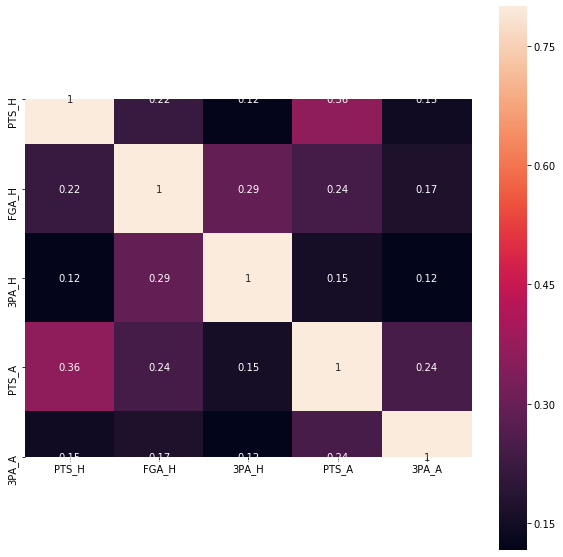

In [19]:
corrmat = nba_data[final_features].corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, cbar=True, square=True, annot=True)

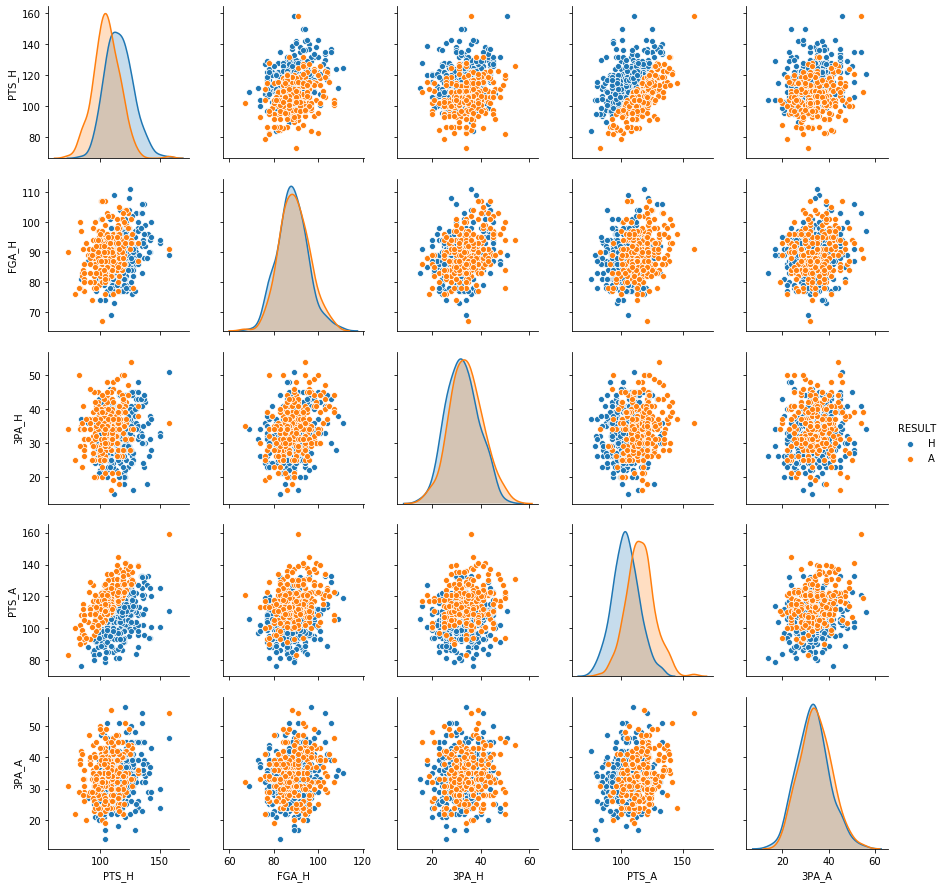

In [20]:
f = final_features.copy()
f.append('RESULT')
sns.pairplot(nba_data[f], hue="RESULT")

In [21]:
final_features

['PTS_H', 'FGA_H', '3PA_H', 'PTS_A', '3PA_A']

In [96]:
columns = [ 'FGA_H', 'PTS_H', '3PA_H', 'FTA_H', 'REB_H', 'STL_H', 'BLK_H', 'TOV_H', 'PF_H']
columns = final_features.copy()

#features = [col[:-2] for col in columns]
#features.insert(0,'HOME')
#new_cols = columns
#new_cols.insert(0,'HOME')
d = nba_data.groupby(by=['HOME']).mean()[columns]
d.columns = columns

features_home = []
features_away = []
for col in columns:
    if col.endswith('H') == True:
        features_home.append(col)
    else:
        features_away.append(col)
print(features_home,features_away)
#d.sort_values(by=list(imp.sort_values([1], ascending=False)[0]))

['PTS_H', 'FGA_H', '3PA_H'] ['PTS_A', '3PA_A']


In [102]:
data_final = nba_data[['HOME', 'AWAY', 'RESULT']]
data_final['ELO_H'] = data_final['HOME'].map(elo)
data_final['ELO_A'] = data_final['AWAY'].map(elo)
data_final = data_final.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')
data_final.head()

/home/michal/PycharmProjects/ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/michal/PycharmProjects/ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,HOME,AWAY,RESULT,ELO_H,ELO_A,PTS_H,FGA_H,3PA_H,PTS_A,3PA_A
0,TOR,NOP,H,1717.569022,1634.770301,115.105263,88.263158,35.368421,116.555556,33.833333
1,LAC,NOP,H,1732.728581,1634.770301,117.450000,90.900000,33.350000,116.555556,33.833333
2,BKN,NOP,H,1655.439913,1634.770301,109.625000,87.625000,35.625000,116.555556,33.833333
3,CHA,NOP,A,1649.223692,1634.770301,107.210526,86.736842,34.000000,116.555556,33.833333
4,DAL,NOP,H,1713.866809,1634.770301,115.684211,89.578947,40.263158,116.555556,33.833333


In [103]:
dataset = data_final.drop(['HOME', 'AWAY'], axis=1)
dataset.head()

,RESULT,ELO_H,ELO_A,PTS_H,FGA_H,3PA_H,PTS_A,3PA_A
0,H,1717.569022,1634.770301,115.105263,88.263158,35.368421,116.555556,33.833333
1,H,1732.728581,1634.770301,117.450000,90.900000,33.350000,116.555556,33.833333
2,H,1655.439913,1634.770301,109.625000,87.625000,35.625000,116.555556,33.833333
3,A,1649.223692,1634.770301,107.210526,86.736842,34.000000,116.555556,33.833333
4,H,1713.866809,1634.770301,115.684211,89.578947,40.263158,116.555556,33.833333


In [370]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['RESULT'],axis=1).values , dataset['RESULT'].values, test_size = 0.3)

In [371]:
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)

clf_RF.score(X_test, y_test)
#clf_RF.feature_importances_

0.6121212121212121

In [372]:
clf_GB = GradientBoostingClassifier()
clf_GB.fit(X_train, y_train)
clf_GB.score(X_test, y_test)

0.6606060606060606

In [373]:
clf_KNN = KNeighborsClassifier()
clf_KNN.fit(X_train, y_train)
clf_KNN.score(X_test, y_test)

0.6848484848484848

In [374]:
clf_SVM = LinearSVC(max_iter=100000)
clf_SVM.fit(X_train, y_train)
clf_SVM.score(X_test, y_test)

/home/michal/PycharmProjects/ML/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6484848484848484

In [379]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
from sklearn.metrics import f1_score

# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf_XGB = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf_XGB,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf_XGB = grid_obj.best_estimator_
print(clf_XGB)

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))



# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf_XGB, X_train, y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf_XGB, X_test, y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.8, verbosity=1)
F1 score and accuracy score for training set: 0.8223 , 0.7827.
F1 score and accuracy score for test set: 0.7363 , 0.7091.


## 7/01/2020

In [386]:
home = ['CLE', 'TOR', 'BKN', 'MEM', 'PHX', 'LAL']
away = ['DET', 'POR', 'OKC', 'MIN', 'SAC', 'NYK']
predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )


predictions['Actual Result'] = ['A', 'A', 'A', 'H', 'A', 'H']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')
predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

clf.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
np.round(np.max(clf.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

array([0.55, 0.83, 0.59, 0.57, 0.57, 0.92], dtype=float32)

In [387]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


In [385]:
predictions

,HOME,AWAY,Actual Result,Random Forest,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,KNN,SVM,Logistic Regression,LR_prob
0,CLE,DET,A,A,0.72,A,0.66,A,0.55,H,A,A,0.66
1,TOR,POR,A,H,0.80,H,0.86,H,0.83,A,A,H,0.86
2,BKN,OKC,A,A,0.61,A,0.80,A,0.59,A,A,A,0.80
3,MEM,MIN,H,H,0.78,H,0.55,H,0.57,H,A,H,0.55
4,PHX,SAC,A,H,0.87,H,0.51,H,0.57,H,A,H,0.51
5,LAL,NYK,H,H,0.99,H,0.94,H,0.92,H,H,H,0.94


## 8/1/2020

In [388]:
home = ['CHA', 'IND', 'BOS', 'ORL', 'DAL', 'ATL','NOP', 'UTA', 'GSW']
away = ['TOR', 'MIA', 'SAS', 'WAS', 'DEN', 'HOU', 'CHI', 'NYK', 'MIL']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
predictions['Actual Result'] = ['A', 'A', 'A', 'H', 'A', 'A', 'H', 'H', 'A']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

In [389]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


In [390]:
predictions

,HOME,AWAY,Actual Result,Random Forest,KNN,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,CHA,TOR,A,A,A,0.85,A,0.92,A,0.77,A,0.92
1,IND,MIA,A,H,H,0.68,H,0.56,H,0.51,H,0.56
2,BOS,SAS,A,H,H,0.96,H,0.97,H,0.91,H,0.97
3,ORL,WAS,H,H,H,0.91,H,0.92,H,0.79,H,0.92
4,DAL,DEN,A,A,A,0.59,A,0.78,A,0.68,H,0.78
5,ATL,HOU,A,A,A,0.75,A,0.77,A,0.77,A,0.77
6,NOP,CHI,H,A,A,0.70,A,0.51,H,0.55,H,0.51
7,UTA,NYK,H,H,H,0.96,H,0.91,H,0.90,H,0.91
8,GSW,MIL,A,A,A,0.75,A,0.86,A,0.77,A,0.86


## 9/1/2020

In [394]:
home = ['PHI', 'DET', 'MIN', 'OKC']
away = ['BOS', 'CLE', 'POR', 'HOU']

predictions = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'] )
#predictions['Actual Result'] = ['A', 'A', 'A', 'H', 'A', 'A', 'H', 'H', 'A']

match = pd.DataFrame(zip(home,away), columns = ['HOME', 'AWAY'])
match['ELO_H'] = match['HOME'].map(elo)
match['ELO_A'] = match['AWAY'].map(elo)
pred=match.merge(d[features_home], on = 'HOME').merge(d[features_away], left_on='AWAY', right_on='HOME')



In [396]:
predictions['KNN'] = clf_KNN.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['Random Forest'] = clf_RF.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)

predictions['RF_prob'] = np.round(np.max(clf_RF.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Gradient Boosting'] = clf_GB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['GB_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)

predictions['XGradient Boosting'] = clf_XGB.predict(pred.drop(['HOME', 'AWAY'],axis=1).values)
predictions['XGB_prob'] = np.round(np.max(clf_XGB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


predictions['Logistic Regression'] = clf_LR.predict(pred.drop(['HOME', 'AWAY'],axis=1).values )
predictions['LR_prob'] = np.round(np.max(clf_GB.predict_proba(pred.drop(['HOME', 'AWAY'],axis=1).values ), axis=1),2)


In [397]:
predictions

,HOME,AWAY,KNN,Random Forest,RF_prob,Gradient Boosting,GB_prob,XGradient Boosting,XGB_prob,Logistic Regression,LR_prob
0,PHI,BOS,H,H,0.95,H,0.95,H,0.83,H,0.95
1,DET,CLE,H,H,0.58,H,0.75,H,0.69,H,0.75
2,MIN,POR,A,H,0.75,H,0.70,H,0.56,A,0.70
3,OKC,HOU,A,H,0.60,H,0.66,H,0.57,H,0.66
